<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">
           <a href="https://bokeh.org/">     
           </a>    
       </td>
       <td style="border:none">
           <h1>Uncertainty Spillover</h1>
       </td>
   </tr>
</table>

<div style="float:right;"><h2>05. Jump damage</h2></div>

In [82]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams["legend.frameon"] = False

In [72]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.array([0, 2*0.0197, 2*0.3853])
γ3_list = np.linspace(0,1/3, 40)
# y grid
numy_bar = 100
y_min = 1e-10
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [73]:
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [74]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \eta \log\tilde e \\
    & +  \frac{d\phi}{dy}\sum_i \pi_i^a\theta_i \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2} \frac{(\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \sum_i \pi_i^a\theta_i + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) +  \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + [ \frac{d\phi}{dy}    + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)]\cdot \tilde e \sigma_y h +\frac{1}{2}\frac{ (\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [75]:
def simulate_jump(y_grid, solu, ME,  θ_list, y_start=1, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y = y_start
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [75]:
def simulate_jump_tilt(y_grid, solu, ME,  θ_list, y_start=1, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y = y_start
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*(θ_list@π)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [76]:
def plot_solu(ht, πᵈt, ϕ_list, solu, args):
    ϕ = solu['φ']
    ξa, ξw, ξp, numy_bar, dmg_weight = args
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
    fig.suptitle(r'$\xi_a = {}, \quad  \xi_w =1/{}, \quad \xi_p = 1/{} $'.format(ξa, int(1/ξw), int(1/ξp)))
    ax1.plot(ht)
    ax1.set_ylim(bottom=0, top=0.3)
    ax1.set_xlim(left=0)
    ax1.set_xlabel('years')
    ax1.set_ylabel('h')
    if np.count_nonzero(dmg_weight) > 2:
        ax2.plot(πᵈt[:,-1][πᵈt[:,-1]>0], label="extreme damage")
    ax2.plot(πᵈt[:,1][πᵈt[:,1]>0], label="high damage")
    ax2.plot(πᵈt[:,0][πᵈt[:,0]>0], label="low damage")
    # ax2.plot(πᵈt[:,2], label="extreme")
    ax2.set_ylim(bottom=0, top=1)
    ax2.set_xlim(left=0)
    ax2.legend()
    ax2.set_xlabel('years')
    ax2.set_ylabel('πᵈ')
    # plot 3
    ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
    ϕ_bound = -ξp*np.log(ϕ_bound)
    ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
    ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
    ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
    ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
    if np.count_nonzero(dmg_weight) > 2:
        ax3.plot(y_grid[numy_bar:], ϕ_list[-1][numy_bar:], linestyle=":", color="black", label="post jump, extreme damage")
    ax3.vlines(x=2, ymin=-11, ymax=5, linestyle="dashed", color="black")
    # ax3.xlim(0,4)
    # ax3.ylim(-0.02, 0.05)
    ax3.set_ylabel('$\phi$')
    ax3.set_xlabel('y')
    ax3.set_xlim(left=0)
    ax3.legend()
    # ax3.set_title(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p = 1/400 \times 5 $')
    # plt.savefig("phi_x1.pdf", facecolor="w", edgecolor='w', bbox_inches="tight") 

In [177]:
ξa = 100_000
ξw = 0.3
ξp = 0.3
dmg_weight = np.ones(len(γ3_list))/len(γ3_list)

solu_dict = dict()
simul_dict = dict()
for y_bar in [1.6, 1.9]:
    numy_bar = 100
    y_min = 0
    y_max = 4
    hy = (y_bar - y_min)/(numy_bar-1)
    y_grid = np.arange(y_min, y_max+hy, hy)
    args = (δ, η, θ_list, γ1, γ2, γ3_list, y_bar, dmg_weight, ς, ξp, ξa, ξw, σy)
    solu, ϕ_list, π_list = approach_one_100(y_grid, numy_bar, args, report_π=True)
    ems_star = solu['ems']
    me,  ratio = solve_baseline(y_grid, numy_bar, ems_star, solu, ϕ_list, args)
    simul = simulate_jump(y_grid[:numy_bar+1], solu, me, θ_list,y_start=1.1)
    solu_dict[y_bar] = solu
    simul_dict[y_bar] = simul

episode: 10000,	 ode error: 9.403177917662042e-05,	 ft error: 9.76379110984027e-05
episode: 10000,	 ode error: 0.00024836270932464266,	 ft error: 4.053111917349621e-05
episode: 10000,	 ode error: 0.0002143926662824744,	 ft error: 4.77955493686603e-05
episode: 4944,	 ode error: 0.00019911249344174708,	 ft error: 9.834516164393866e-09
episode: 5018,	 ode error: 0.00023523634911450098,	 ft error: 9.93830573392529e-09
episode: 5069,	 ode error: 0.00027325735406873164,	 ft error: 9.982212093954484e-09
episode: 5113,	 ode error: 0.0003151778889173354,	 ft error: 9.95473629454106e-09
episode: 5147,	 ode error: 0.0003633210627978292,	 ft error: 9.969679896452515e-09
episode: 5146,	 ode error: 0.00029076087811370777,	 ft error: 9.987661068559344e-09
episode: 5168,	 ode error: 0.0003215517123584741,	 ft error: 9.974900905262984e-09
episode: 5192,	 ode error: 0.0003554743245011288,	 ft error: 9.972428808661487e-09
episode: 5214,	 ode error: 0.0003934753047606966,	 ft error: 9.993765814897415e-09


Text(0.5, 1.0, '$N_t$')

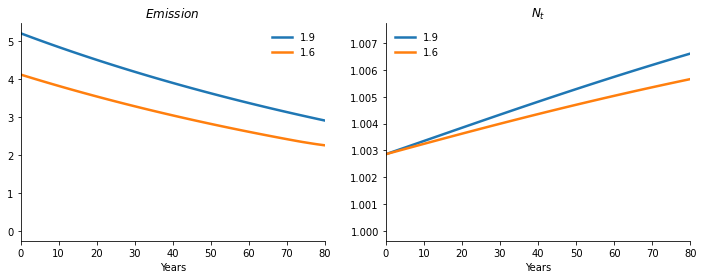

In [189]:
plt.figure(figsize=(12,4))
plt.subplot(121)
for y_bar in [1.9, 1.6]:
    et = simul_dict[y_bar][1]
    plt.plot(et, label="{}".format(y_bar))
    
plt.xlim(0, 80)
plt.xlabel("Years")
plt.legend()
plt.title("$Emission$")

plt.subplot(122)
for y_bar in [1.9, 1.6]:
    yt = simul_dict[y_bar][0]
    logNt = γ1*yt + γ2/2*yt**2
    plt.plot(np.exp(logNt), label="{}".format(y_bar))
    
plt.xlim(0, 80)
plt.xlabel("Years")
plt.legend()
plt.title("$N_t$")

In [ ]:
f

In [ ]:
for y_bar in [1.6, 1.9]:
    numy_bar = 100
    y_min = 0
    y_max = 4
    hy = (y_bar - y_min)/(numy_bar-1)
    y_grid = np.arange(y_min, y_max+hy, hy)
    args = (δ, η, θ_list, γ1, γ2, γ3_list, y_bar, dmg_weight, ς, ξp, ξa, ξw, σy)
    solu, ϕ_list, π_list = approach_one_100(y_grid, numy_bar, args, report_π=True)
    ems_star = solu['ems']
    me,  ratio = solve_baseline(y_grid, numy_bar, ems_star, solu, ϕ_list, args)
    yt, et, πᵈt, πᶜt, ιt, ht, me_t = simulate_jump(y_grid[:numy_bar+1], solu, me, θ_list,y_start=1.1)
    solu_dict[y_bar] = solu
    ems_dict[y_bar] = et
    y_dict[y_bar] = yt
    me_dict[y_bar] = me_t
    πd_dict[y_bar] = πᵈt

Text(0.5, 1.0, 'Emission')

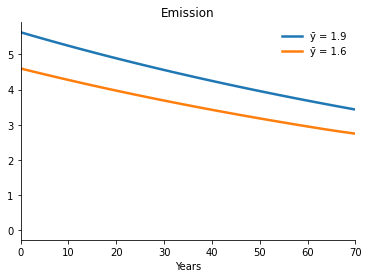

In [176]:
plt.plot(ems_dict[1.9], label="ȳ = 1.9")
plt.plot(ems_dict[1.6], label="ȳ = 1.6")
# plt.plot(ems_dict[2], label="ȳ = 2")
plt.xlim(0, 70)
plt.legend()
plt.xlabel("Years")
plt.title("Emission")
# plt.savefig("ems_1_6_1_9.png", facecolor='w', edgecolor='w', dpi=400)

In [126]:
γ3_list[19]

0.16239316239316237

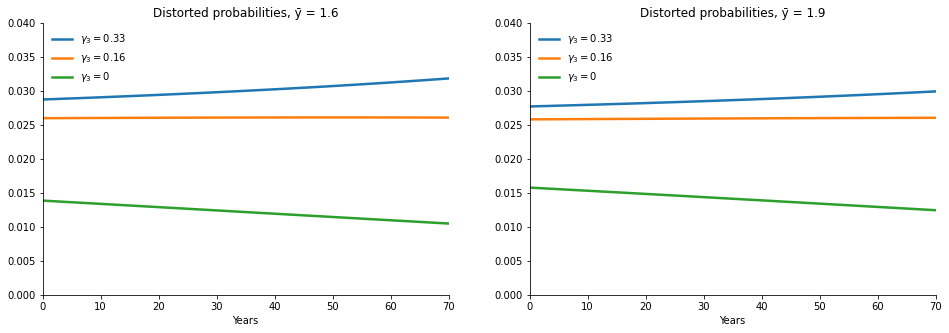

In [148]:
plt.subplots(figsize=(16,5))
plt.subplot(121)
plt.plot(πd_dict[1.6][:,-1], label="$\gamma_3 = 0.33$")
plt.plot(πd_dict[1.6][:, 20-1], label="$\gamma_3 = 0.16$")
plt.plot(πd_dict[1.6][:, 0], label="$\gamma_3 = 0$")

# plt.plot(πd_dict[1.6], label="ȳ = 1.6")
# plt.plot(ems_dict[2], label="ȳ = 2")
plt.xlim(0, 70)
plt.ylim(0, 0.04)
plt.legend()
plt.xlabel("Years")
plt.title("Distorted probabilities, ȳ = 1.6")

plt.subplot(122)


plt.plot(πd_dict[1.9][:,-1], label="$\gamma_3 = 0.33$")
plt.plot(πd_dict[1.9][:, 20-1], label="$\gamma_3 = 0.16$")
plt.plot(πd_dict[1.9][:, 0], label="$\gamma_3 = 0$")

# plt.plot(πd_dict[1.6], label="ȳ = 1.6")
# plt.plot(ems_dict[2], label="ȳ = 2")
plt.xlim(0, 70)
plt.ylim(0, 0.04)
plt.legend(loc=2)
plt.xlabel("Years")
plt.title("Distorted probabilities, ȳ = 1.9")

# plt.savefig("distorted_prob.png", facecolor='w', edgecolor='w', dpi=400)

In [168]:
πd_dict[1.6][70]

array([0.01048975, 0.01325745, 0.01500245, 0.01634158, 0.01747257,
       0.01843351, 0.019286  , 0.02003074, 0.0207295 , 0.0213758 ,
       0.02197906, 0.02254239, 0.02303853, 0.02353652, 0.02400936,
       0.02445975, 0.02488996, 0.02530193, 0.02569733, 0.02607764,
       0.02644416, 0.02679802, 0.02714023, 0.02747167, 0.02779314,
       0.02810532, 0.02840884, 0.02870424, 0.02899204, 0.02927267,
       0.02954655, 0.02981404, 0.0300755 , 0.03033121, 0.03058149,
       0.03082657, 0.03106672, 0.03130215, 0.03153308, 0.03184054])

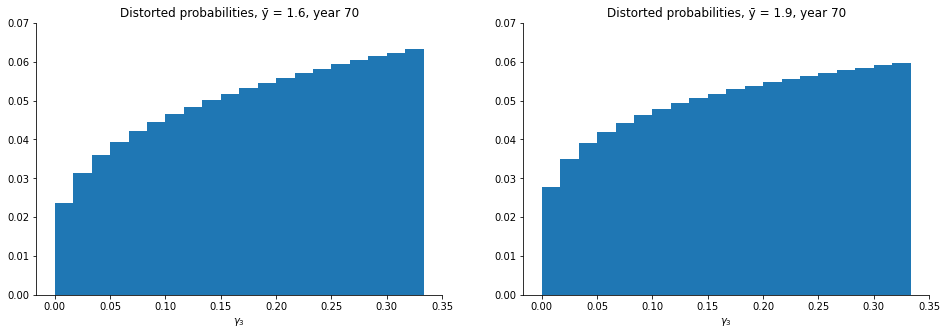

In [165]:
plt.subplots(figsize=(16,5))
plt.subplot(121)
plt.hist(γ3_list, weights=πd_dict[1.6][70], bins=20)
# plt.plot(πd_dict[1.6][:, 20-1], label="$\gamma_3 = 0.16$")
# plt.plot(πd_dict[1.6][:, 0], label="$\gamma_3 = 0$")

# plt.plot(πd_dict[1.6], label="ȳ = 1.6")
# plt.plot(ems_dict[2], label="ȳ = 2")
# plt.xlim(0, 70)
plt.ylim(0, 0.07)
# plt.legend()
plt.xlabel("$\gamma_3$")
plt.title("Distorted probabilities, ȳ = 1.6, year 70")

plt.subplot(122)


plt.hist(γ3_list, weights=πd_dict[1.9][70], bins=20)
# plt.plot(πd_dict[1.9][:, 20-1], label="$\gamma_3 = 0.16$")
# plt.plot(πd_dict[1.9][:, 0], label="$\gamma_3 = 0$")

# plt.plot(πd_dict[1.6], label="ȳ = 1.6")
# plt.plot(ems_dict[2], label="ȳ = 2")
# plt.xlim(0, 70)
plt.ylim(0, 0.07)
# plt.legend(loc=2)
plt.xlabel("$\gamma_3$")
plt.title("Distorted probabilities, ȳ = 1.9, year 70")

# plt.savefig("distorted_prob_hist.png", facecolor='w', edgecolor='w', dpi=400)

Text(0.5, 1.0, 'Emission')

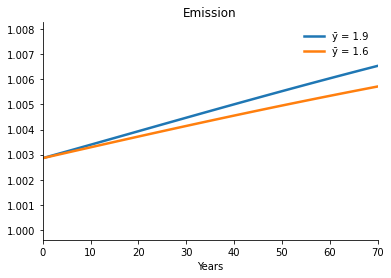

In [175]:
logN1 = γ1*y_dict[1.9] + γ2/2*y_dict[1.9]**2
logN2 = γ1*y_dict[1.6] + γ2/2*y_dict[1.6]**2

plt.plot(np.exp(logN1), label="ȳ = 1.9")
plt.plot(np.exp(logN2), label="ȳ = 1.6")
# plt.plot(y_dict[1.6], label="ȳ = 2")
plt.xlim(0, 70)
plt.legend()
plt.xlabel("Years")
plt.title("Emission")
# plt.savefig("ems_1_6_1_9.png", facecolor='w', edgecolor='w', dpi=400)

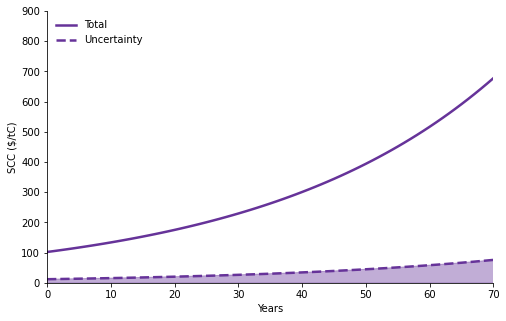

In [113]:
# 1.9
logkt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0,)
MCt = (1 - η)/((α - invkap)*np.exp(logkt))


fig = plt.figure(figsize=(8,5))
scc = η/ems_dict[1.9][ems_dict[1.9] > 0]/MCt*1000
scc0 = me_dict[1.9]/MCt*1000 
plt.plot(scc, color="rebeccapurple", label="Total")

plt.plot(scc -scc0, color="rebeccapurple", linestyle="dashed", label="Uncertainty")
plt.fill_between(np.arange(0, 100, 1), np.zeros_like(scc), 
                 scc-scc0, color='rebeccapurple', alpha=.4)
plt.xlim(0,70)
plt.ylim(0,900)
plt.xlabel("Years")
plt.ylabel("SCC ($/tC)")
plt.legend(loc=2)
# plt.savefig("scc_1_9.png", dpi=500)

In [114]:
(scc -scc0)/scc

array([0.1165056 , 0.11647789, 0.11641566, 0.11640125, 0.1163259 ,
       0.11631912, 0.11623538, 0.11622035, 0.11614331, 0.11612179,
       0.11604904, 0.11602302, 0.1159521 , 0.11592382, 0.1158522 ,
       0.11582415, 0.11574925, 0.11572423, 0.11564337, 0.11562449,
       0.11553494, 0.11552569, 0.11542456, 0.11541259, 0.11531318,
       0.11528699, 0.11520204, 0.11515861, 0.11509278, 0.11502893,
       0.11498743, 0.11489983, 0.11488853, 0.11477364, 0.11474852,
       0.11465322, 0.11459785, 0.11454201, 0.11445255, 0.11444412,
       0.11431646, 0.11427923, 0.11419418, 0.11411543, 0.11409118,
       0.11396633, 0.1139322 , 0.11383801, 0.11375414, 0.11373764,
       0.11359888, 0.11355155, 0.11347441, 0.11336813, 0.11335283,
       0.11321903, 0.1131405 , 0.1131148 , 0.1129668 , 0.11291119,
       0.11284355, 0.11271356, 0.11267589, 0.11257303, 0.11245576,
       0.11243085, 0.11230061, 0.11219051, 0.11217295, 0.11202449,
       0.11191575, 0.11189986, 0.11174393, 0.11163048, 0.11161

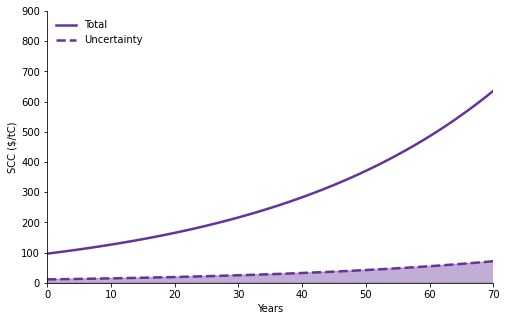

In [111]:
# 2
logkt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0,)
MCt = (1 - η)/((α - invkap)*np.exp(logkt))


fig = plt.figure(figsize=(8,5))
scc = η/ems_dict[2][ems_dict[2] > 0]/MCt*1000
scc0 = me_dict[2]/MCt*1000 
plt.plot(scc, color="rebeccapurple", label="Total")

plt.plot(scc -scc0, color="rebeccapurple", linestyle="dashed", label="Uncertainty")
plt.fill_between(np.arange(0, 100, 1), np.zeros_like(scc), 
                 scc-scc0, color='rebeccapurple', alpha=.4)
plt.xlim(0,70)
plt.ylim(0,900)
plt.xlabel("Years")
plt.ylabel("SCC ($/tC)")
plt.legend(loc=2)
# plt.savefig("scc_1_9.png", dpi=500)

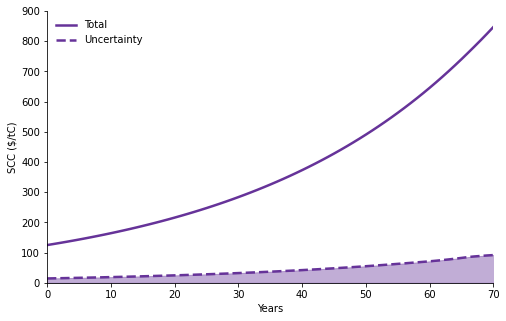

In [92]:
logkt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0,)
MCt = (1 - η)/((α - invkap)*np.exp(logkt))


fig = plt.figure(figsize=(8,5))
scc = η/ems_dict[1.6][ems_dict[1.6] > 0]/MCt[ems_dict[1.6] > 0]*1000
scc0 = me_dict[1.6][ems_dict[1.6] > 0]/MCt[ems_dict[1.6] > 0]*1000 
plt.plot(scc, color="rebeccapurple", label="Total")

plt.plot(scc -scc0, color="rebeccapurple", linestyle="dashed", label="Uncertainty")
plt.fill_between(np.arange(0, len(scc)), np.zeros_like(scc), 
                 scc-scc0, color='rebeccapurple', alpha=.4)
plt.xlim(0,70)
plt.ylim(0, 900)
plt.xlabel("Years")
plt.ylabel("SCC ($/tC)")
plt.legend(loc=2)
# plt.savefig("scc_1_6.png", dpi=500)

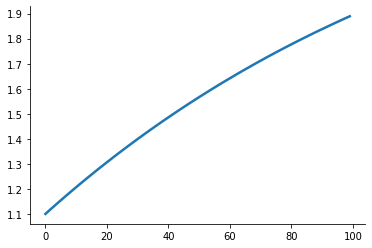

In [38]:
plt.plot(yt)

In [25]:
def solve_baseline(y_grid, numy_bar, ems_star, solu, ϕ_list, args, ϵ=1, tol=1e-7, max_iter=10_000):
    """
    compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy = args
#     ems_star = solu['ems']
    # solve for HJB with jump function
    y_grid_cap = y_grid[:numy_bar+1]
    dy = y_grid_cap[1] - y_grid_cap[0]
    dΛ = γ1 + γ2*y_grid_cap
    ddΛ = γ2
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    θ = θ_list@πᶜo 
    A = -δ*np.ones(y_grid_cap.shape)
    B = θ*ems_star
    C = σy**2*ems_star**2/2
    D = η*np.log(ems_star) + (η-1)/δ*dΛ*ems_star*θ + (η-1)/δ*ddΛ*ems_star**2*σy**2/2
    ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]
    ϕ = ϕ_bound
    episode = 0
    lhs_error = 1
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, "up")
        # solver
        ϕ_new = solve_ode(A, B, C, D, y_grid_cap, ϕ, ϵ, (True, ϕ_bound[numy_bar]))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

#     dϕdy = derivative_1d(ϕ, 1, dy, "center")
#     dϕdyy = derivative_1d(ϕ, 2, dy, "center")
    
    ME = -(dϕdy+(η-1)/δ*dΛ)*θ - (dϕdyy+(η-1)/δ*ddΛ)*σy**2*ems_star
    ratio = ME/(η/ems_star)

    return ME, ratio

In [ ]:
ems_star = solu_dict[1.6]


In [ ]:
y_bar = 1.9
numy_bar = 100
y_min = 1e-10
y_max = 4
hy = (y_bar - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)
args = (δ, η, θ_list, γ1, γ2, γ3_list, y_bar, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list, π_list = approach_one_100(y_grid, numy_bar, args, report_π=True)
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu_dict[1.9], None, θ_list,y_start=1.1)

In [ ]:
fig,ax3 = plt.subplots()
ϕ = solu["φ"]
ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
ϕ_bound = -ξp*np.log(ϕ_bound)
ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
if np.count_nonzero(dmg_weight) > 2:
    ax3.plot(y_grid[numy_bar:], ϕ_list[-1][numy_bar:], linestyle=":", color="black", label="post jump, extreme damage")
ax3.vlines(x=y_bar, ymin=-11, ymax=5, linestyle="dashed", color="black")
# ax3.xlim(0,4)
# ax3.ylim(-0.02, 0.05)
ax3.set_ylabel('$\phi(y)$')
ax3.set_xlabel('y')
ax3.set_xlim(left=0)
ax3.legend(loc=(1,0.5))

In [ ]:
plt.plot(solu['πd'].T)
plt.ylim(0,1)

In [ ]:
# histogram 10, 50, 90
from matplotlib.ticker import MaxNLocator
fig,ax2 = plt.subplots(1, 1,figsize=(6,5))
# ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

# ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)
bins = np.linspace(0, 3, 21)

ax2.hist(θ_list*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.hist(θ_list*1000, weights=πᶜt[50]*np.exp(-δ*50), bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Density', fontsize=13)
# ax2.set_title('Mean difference: {:.2f} '.format( (θ_list@πᶜt[50]-np.mean(θ_list) + σy*ht[50])*1000 ) )
ax2.set_ylim(0,1.5)
ax2.set_xticks(np.arange(0,3+0.5, 0.5))
ax2.set_xlim(0.8, 3)
# ax2.hist(θ_list*1000, weights=πᶜt[50]*np.exp(-50*δ), density=True, bins=np.linspace(1,3,14), color="tab:blue", ec="grey", alpha=0.5)
# ax2.set_xlabel('Climate sensitivity', fontsize=13)
# ax2.set_ylabel('Distorted density (year 50)', fontsize=13)
# ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax2.hist(θ_list*1000, density=True, bins=np.linspace(1,3,14), color="tab:red", ec="grey", alpha=0.5)
# ax2.set_xlabel('Climate sensitivity', fontsize=13)
# ax2.set_ylabel('Distorted density (year 50)', fontsize=13)



# ax3.hist(θ_list*1000, weights=πt_avg[90]*np.exp(-90*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
# ax3.set_xlabel('Climate sensitivity', fontsize=13)
# ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# ax3.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax3.set_xlabel('Climate sensitivity', fontsize=13)
# ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# plt.savefig('./paper_plots/histogram_worstcase.pdf')

In [ ]:
# histogram θ_list
fig,ax2 = plt.subplots(1, 1,figsize=(6,5))
# ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

# ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)
bins = np.linspace(0, 3, 21)

ax2.hist(θ_list*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.6, density=True)
# ax2.hist(θ_list*1000, weights=πᶜt[50], bins=bins, color='tab:blue', histtype='bar', ec='darkgray', alpha=.5, density=True)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Density', fontsize=13)
# ax2.set_title('Mean difference: {:.2f} '.format( (θ_list@πᶜt[50]-np.mean(θ_list) + σy*ht[50])*1000 ) )
ax2.set_ylim(0,1.5)
ax2.set_xticks(np.arange(0,3+0.5, 0.5))
ax2.set_xlim(0.8, 3)

# plt.savefig('./paper_plots/histogram.pdf')

In [14]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt
def simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt, T=100, dt=1):
    Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0)
    MCt = (1-η)/((α - invkap)*np.exp(Kt))
    SCCt = MEt/MCt*1000
    return SCCt

In [ ]:
MEt = η/et
SCCt = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt)
plt.plot(SCCt, label="ȳ = 1.9")

me_t = η/ems_dict[2]
scc = simulate_scc(invkap, αₖ,  σₖ, κ, k0, me_t)
plt.plot(scc, label='ȳ = 2')
plt.legend(title='$Y_0 = 1.1$')

In [ ]:
ξa = 1/10_000*100
ξw = 1000*100
ξp = 1/20*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_unreveal, ems_unreveal, π_unreveal = solve_smooth_unreveal(y_grid, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

In [ ]:
def simulate_unreveal(y_grid, ems, π, me, θ_list, y_start=1, T=100, dt=1):
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πt = np.zeros((periods, len(π)))
    me_t = np.zeros(periods)
    get_π = interpolate.interp1d(y_grid, π)
#     y = np.mean(θ_list)*290
    y = y_start
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            π_list = get_π(y)
            if me is not None:
                me_point = np.interp(y, y_grid, me)
                me_t[t] = me_point
            et[t] = ems_point
            πt[t] = π_list
            
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    
    return yt, et, πt, me_t

In [ ]:
logKt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0,)

In [ ]:
yt_unreveal, et_unreveal, πt_unreveal, _ = simulate_unreveal(y_grid, ems_unreveal, π_unreveal, None, θ_list, T=200)

In [ ]:
plt.plot(et[et>0], label="with threshold")
plt.plot(et_unreveal[:100], label="without threshold")
plt.ylim(0,11)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("Emission")
plt.title("Emission trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/ems_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [ ]:
plt.plot(yt[yt>0], label="with threshold")
plt.plot(yt_unreveal[yt_unreveal<=2], label="without threshold")
plt.ylim(0)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("$y_t$")
plt.title("$Y_t$ trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/ems_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [ ]:
SCCt_unreveal = η*(α - invkap)*np.exp(logKt)/(1-η)/et_unreveal[:100]*1000
plt.plot(SCCt, label="with threshold")
plt.plot(SCCt_unreveal, label="without threshold")
plt.ylim(0,1700)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("SCC")
plt.title("SCC \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/scc_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [ ]:
ξa = 1000*100
ξw = 1000*100
ξp = 1000*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args,)
yt_base, et_base, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)

In [ ]:
plt.plot(et_base[et_base>0])

In [ ]:
ξa = 1000*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_unreveal_base, ems_unreveal_base, π_unreveal_base = solve_smooth_unreveal(y_grid, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

In [ ]:
yt_unreveal_base, et_unreveal_base, πt_unreveal_base, _ = simulate_unreveal(y_grid, ems_unreveal_base, π_unreveal_base, None, θ_list, T=200)

In [ ]:
plt.plot(et_base, label="with jump")
plt.plot(et_unreveal_base[:100], label="without jump")
plt.ylim(0,11)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("Emission")
plt.title("Emission trajectories \n $ξ_a = \infty, ξ_p = \infty$ for with jump\n $ξ =\infty$ for without jump")
# plt.savefig("./paper_plots/ems_nojumpcompare_base.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [ ]:
SCCt_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_base*1000
SCCt_unreveal_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_unreveal_base[:100]*1000
plt.plot(SCCt_base, label="with jump")
plt.plot(SCCt_unreveal_base, label="without jump")
plt.ylim(0,1400)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("SCC")
plt.title("SCC \n $ξ_a = \infty, ξ_p = \infty$ for with jump\n $ξ = \infty$ for without jump")
# plt.savefig("./paper_plots/scc_nojumpcompare_base.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [ ]:
n_climate = len(θ_list)
n_dmg = len(γ3_list)
πc_dict = dict()
for year in [10,50,90, -1]:
    πc_dict[year] = np.sum(πt_unreveal[year].reshape(n_climate, n_dmg), axis=1)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
axes = [ax1, ax2, ax3]
bins=np.linspace(1,3,15)
ax1.set_title("Year 10")
ax1.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray", color="tab:red" )
ax1.hist(θ_list*1000, weights=πc_dict[10], bins=bins, density=True, alpha=0.5, ec="gray", color="tab:blue")

ax2.set_title("Year 50")
ax2.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray",color="tab:red" )
ax2.hist(θ_list*1000, weights=πc_dict[50]*np.exp(-50*δ), bins=bins, density=True, alpha=0.5, ec="gray",color="tab:blue")

ax3.set_title("Year 90")
ax3.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray", color="tab:red" )
ax3.hist(θ_list*1000, weights=πc_dict[90]*np.exp(-90*δ), bins=bins, density=True, alpha=0.5, ec="gray", color="tab:blue")

fig.tight_layout()
# fig.savefig("./paper_plots/hist_time.png", facecolor="w",dpi=500)

In [ ]:
πd_list = np.zeros((200,3))
for year in range(200):
    πd_list[year] = np.sum(πt_unreveal[year].reshape(n_climate, n_dmg), axis=0)

# Decompose  for no jump version

In [ ]:
def solve_smooth_unreveal_decompose(y_grid, ems_star, args, max_iter, tol, ϵ,):
    """
    solve for step one, ϕⱼ for individual damage function
    
    Parameter
    ---
    args: δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξa, ξw
    """
    δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw = args
    params = list()
    for θ_i in θ_list:
        for γ3 in γ3_list:
            params.append([θ_i, γ3])
    params = np.array(params)
    θ_long = params[:,0]
    γ3_long = params[:,1]
    args_weight = (δ, η, γ1, γ2, ȳ, σy, ξa)
    dy = y_grid[1] - y_grid[0]
    n_y = len(y_grid)
#     dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
#     ddΛ = γ2 + γ3*(y_grid>ȳ)
    ϕ = - η*y_grid**2
    ems = η
    ems_old = ems
    πo = np.ones((len(params), n_y))/len(params)
    lhs_error = 1
    episode = 0
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, "up")
#         temp1 = dϕdy + (η-1)/δ*dΛ
#         temp2 = dϕdyy + (de)
        # update belief
        weight = generate_weight(params, ems_star, dϕdy, y_grid, args_weight)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
#         temp = dϕdy + (η-1)/δ*(γ1 + γ2*y_grid)
#         ddΛ = γ2 + γ3_long@π*(y_grid>ȳ)
#         a = (dϕdyy  + (η-1)/δ*ddΛ)*σy**2
#         b = (θ_long@π)*temp + (η-1)/δ*((θ_long*γ3_long)@π)*(y_grid - ȳ)*(y_grid>ȳ)
#         c = η
#         Δ = b**2 - 4*a*c
#         Δ[Δ < 0] = 0
#         root1 = (-b - np.sqrt(Δ))/(2*a)
#         root2 = (-b + np.sqrt(Δ))/(2*a)
#         if root1.all() > 0:
#             ems_new = root1
#         else:
#             ems_new = root2
#         ems_new[ems_new < 1e-15] = 1e-15
#         ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        dmg_drift = θ_long@π*(γ1 + γ2*y_grid)*ems_star + (θ_long*γ3_long)@π*(y_grid-ȳ)*(y_grid>ȳ)*ems_star\
        + 1/2*(γ3_long@π)*(y_grid>ȳ)*σy**2*ems_star**2 + 1/2*γ2*σy**2*ems_star**2
        A = - δ*np.ones(y_grid.shape)
        B = (θ_long@π)*ems_star
#         C = np.zeros(y_grid.shape)
        C = ems_star**2*σy**2/2
        D = η*np.log(ems_star) + ξa*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
            + (η-1)/δ*dmg_drift
#         - 1/(2*ξw)*temp**2*ems**2*σy**2\
#         + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
#         ems_old = ems
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    me = - θ_long@π*(dϕdy + (η-1)/δ*(γ1 + γ2*y_grid)) - (η-1)/δ*(θ_long*γ3_long)@π*(y_grid-ȳ)*(y_grid>ȳ) \
        - (η-1)/δ*(γ3_long@π)*(y_grid>ȳ)*σy**2*ems_star - (η-1)/δ*γ2*σy**2*ems_star - dϕdyy*σy**2*ems_star
#     h = - temp*ems*σy/ξw
    return ϕ, ems, π, me

In [ ]:
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_test, ems_test, π_test, me_unreveal = solve_smooth_unreveal_decompose(y_grid, ems_unreveal, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

In [ ]:
ems_10 = 10*np.ones(ems_unreveal.shape)

In [ ]:
ems = ems_unreveal
# ems = ems_10

In [ ]:
# base
ξa = 1000*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_b, ems_b, π_b, me_b = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

In [ ]:
# dmamage 
ξa = 1/100
args_unreveal = (δ, η, [np.average(θ_list)], σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_dmg, ems_dmg, π_dmg, me_dmg = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

In [ ]:
# temp
ξa = 1/100
args_unreveal = (δ, η, θtemp_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_temp, ems_temp, π_temp, me_temp = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

In [ ]:
# carb
ξa = 1/100
args_unreveal = (δ, η, θcarb_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_carb, ems_carb, π_carb, me_carb = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

In [ ]:
# total
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_total, ems_total, π_total, me_total = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

In [ ]:
yt_b, et_b, πt_b, met_b = simulate_unreveal(y_grid, ems, π_b, me_b, θ_list, T=200)
yt_dmg, et_dmg, πt_dmg, met_dmg = simulate_unreveal(y_grid, ems, π_dmg, me_dmg, θ_list, T=200)
yt_temp, et_temp, πt_temp, met_temp = simulate_unreveal(y_grid, ems, π_temp, me_temp, θ_list, T=200)
yt_carb, et_carb, πt_carb, met_carb = simulate_unreveal(y_grid, ems, π_carb, me_carb, θ_list, T=200)
yt_total, et_total, πt_total, met_total = simulate_unreveal(y_grid, ems, π_total, me_total, θ_list, T=200)

In [ ]:
plt.plot(np.log(met_total/met_b)*100, label="total")
plt.plot(np.log(met_dmg/met_b)*100, label="damage")
plt.plot(np.log(met_temp/met_b)*100, label="temperature")
plt.plot(np.log(met_carb/met_b)*100, label="carbon")
plt.ylim(0)
plt.xlabel("Years")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")
plt.tight_layout()
# plt.savefig("./paper_plots/decomp_1type_21.png", dpi=500, facecolor="w")

In [ ]:
plt.plot(y_grid, np.log(me_total/me_b)*100, label="total uncertainty")
plt.plot(y_grid, np.log(me_temp/me_b)*100, label="temperature")
plt.plot(y_grid, np.log(me_carb/me_b)*100, label="carbon")
plt.plot(y_grid, np.log(me_dmg/me_b)*100, label="damge")
plt.xlabel("y")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")

In [ ]:
# dmamage and temp
ξa = 1/100
args_unreveal = (δ, η, θtemp_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_tempdmg, ems_tempdmg, π_tempdmg, me_tempdmg = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

In [ ]:
# dmamage and carb
ξa = 1/100
args_unreveal = (δ, η, θcarb_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_carbdmg, ems_carbdmg, π_carbdmg, me_carbdmg = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

In [ ]:
# temp and carb
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_tempcarb, ems_tempcarb, π_tempcarb, me_tempcarb = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                    args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

In [ ]:
yt_carbdmg, et_carbdmg, πt_carbdmg, met_carbdmg = simulate_unreveal(y_grid, ems, π_carbdmg, me_carbdmg, θ_list, T=200)
yt_tempcarb, et_tempcarb, πt_tempcarb, met_tempcarb = simulate_unreveal(y_grid, ems, π_tempcarb, me_tempcarb, θ_list, T=200)
yt_tempdmg, et_tempdmg, πt_tempdmg, met_tempdmg = simulate_unreveal(y_grid, ems, π_tempdmg, me_tempdmg, θ_list, T=200)

In [ ]:
plt.plot(np.log(met_total/met_b)*100, label="total")
plt.plot(np.log(met_tempdmg/met_b)*100, label="temperature and damage")
plt.plot(np.log(met_carbdmg/met_b)*100, label="carbon and damage")
plt.plot(np.log(met_tempcarb/met_b)*100, label="temperature and carbon")
# plt.plot(np.log(met_tempcarb/met_b)*100, label="temperature and carbon"))
plt.ylim(0)
plt.xlabel("Years")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")
plt.tight_layout()
# plt.savefig("./paper_plots/decomp_2type_21.png", facecolor="w", dpi=500)

In [ ]:
plt.plot(y_grid, np.log(me_total/me_b)*100, label="total uncertainty")
plt.plot(y_grid, np.log(me_tempdmg/me_b)*100, label="temperature and damage")
plt.plot(y_grid, np.log(me_carbdmg/me_b)*100, label="carbon and damage")
plt.plot(y_grid, np.log(me_tempcarb/me_b)*100, label="temperature and carbon")
plt.xlabel("y")
plt.ylim(0)
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")

# SCC uncertainty decomposition: pre jump

First order condition for $\tilde e$

$$
    \left( \frac{d^2\phi(y)}{dy^2} + \frac{(\eta-1)}{\delta}\cdot\gamma_2  \right)|\sigma_y|^2\tilde e + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + \frac{(\eta - 1)}{\delta}(\gamma_1 + \gamma_2 y)\right]\theta_j  + \frac{\eta}{\tilde e} = 0 \tag{$\ast$}
$$

Call solution $\tilde e^* $. Now solve:
$$
\begin{aligned}
0 =  & - \delta \color{red}{\phi(y)}+ \eta \log\tilde e^* + \frac{1}{2} \color{red}{ \frac{d^2 \phi}{dy^2}}\cdot(\tilde e^*)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e^*)^2 |\sigma_y|^2\\
& + \left[\color{red}{\frac{d\phi}{dy}}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e^* \sum_i \pi_i^c \theta_i
\end{aligned}
$$

In [ ]:
def plot_together(et, θ_list, ht, πᶜt, πᵈt, MEt, dmg_weight):
    y_grid_cap = y_grid[:numy_bar+1]
    πᶜo = πᶜo = np.ones(len(θ_list))/len(θ_list)
    # plot
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))
    fig.tight_layout(pad=5)
    # plot 1
    if np.count_nonzero(dmg_weight) > 2:
        ax1.plot(πᵈt[:,-1], label="extreme damage", color="C2")
    ax1.plot(πᵈt[:,1], label="high damage", color="C3")
    ax1.plot(πᵈt[:,0], label="low", color="C0")
    ax1.legend(frameon=False)
    ax1.set_xlabel('Years')
    ax1.set_ylim(0,1)
    ax1.set_xlim(left=0)
    ax1.set_title('distorted probability of damage')
    # plot 2
    bins = np.linspace(1,3,14)
    ax2.hist(θ_list*1000, density=True, color='tab:red', bins=bins, histtype='bar', ec='gray', alpha=.5, )
    ax2.hist((θ_list+σy*ht[49])*1000, weights=πᶜt[49], density=True, color='tab:blue',bins=bins, histtype='bar', ec='gray', alpha=.5,)
    ax2.set_title('mean difference: {:.4f}'.format((θ_list@(πᶜt[49]-πᶜo)+σy*ht[49])*1000))
    ax2.set_xlabel('Climate sensitivity, year 50')
    ax2.set_xlim(0.8,3)
    # plot 3
    ax3.plot(et[et_base>0],label='distorted', color="C3")
    ax3.plot(et_base[et_base>0], label="baseline", color="C0")
    ax3.legend(frameon=False)
    ax3.set_xlabel('Years')
    ax3.set_ylim(bottom=0)
    ax3.set_xlim(left=0)
    ax3.set_title('emission')
    # plot 4
    SCCt_base, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt)
    SCCt_distorted, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, δ*η/et)
#     ax4.plot((δ*η/et[et>0])/MC[et>0]*1000, label="total", color="C3")
    ax4.plot(SCCt_distorted, label="total", color="C3")
#     ax4.plot((ME/MC)[et>0]*1000, label="baseline", color="C0")
    ax4.plot(SCCt_distorted - SCCt_base, label="baseline", color="C0")
    ax4.legend(frameon=False)
    ax4.set_xlabel('Years')
    ax4.set_ylim(bottom=0)
    ax4.set_xlim(left=0)
    ax4.set_title('social cost of carbon')
    
    return fig, ((ax1, ax2), (ax3, ax4))

In [ ]:
def simulate_jump_ems(y_grid, solu, ME,  θ_list, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y=1
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*(θ_list@πᶜ_list + σy*h_point)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [ ]:
ȳ = 1.9

ξa = 100000
ξw = 100000
ξp = 100000
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=3, max_iter=5000)
yt_bb, et_bb, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list, y_start=1.1)
yt_bbw, et_bbw, πᵈt, πᶜt, ιt, ht = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

In [ ]:
plt.plot(et_bb)

In [ ]:
ξa = 100000
ξw = 0.3
ξp = 5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, max_iter=5_000)
yt_3, et_3, πᵈt, πᶜt_3, ιt, ht_3 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list, y_start=1.1)
yt_3w, et_3w, πᵈt, πᶜt_3, ιt, ht_3w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

In [ ]:
# adding equal version 1 
ξa = 100000
ξw = 0.3
ξp = 0.3
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_e1, et_e1, πᵈt, πᶜt, ιt, ht_e1 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list, y_start=1.1)
yt_e1w, et_e1w, πᵈt, πᶜt, ιt, ht_e1w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

In [ ]:
# adding equal version 2
ξa = 1000*100
ξw = 1/20*100
ξp = 1/20*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_e2, et_e2, πᵈt, πᶜt, ιt, ht_e2 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list, y_start=1.1)
yt_e2w, et_e2w, πᵈt, πᶜt, ιt, ht_e2w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

In [ ]:
#
years = np.arange(0,100)
fig = plt.figure(figsize=(8,5))
plt.plot(years[et_bb>0], et_bb[et_bb>0], label="baseline", color="tab:red")
plt.plot(years[et_bb>0], et_e2[et_bb>0], label="$ξ_b = ξ_p = 5$", color="darkorange")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(years[et_bb>0], et_3[et_bb>0], label="$ξ_b =0.3,  ξ_p = 5$", color="darkgreen")
plt.plot(years[et_bb>0], et_e1[et_bb>0], label="$ξ_b = ξ_p = 0.3$" , color="navy")

# plt.plot(et, label="with drift term + jump robust")
plt.legend(frameon=False, loc=3)
plt.ylim(0,10)
# plt.xlim(right=95)
# plt.xticks(np.arange(0, 91, 10))
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.savefig("./paper_plots/emission_three.pdf")
# plt.savefig("./paper_plots/emission_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")

In [ ]:
#
fig = plt.figure(figsize=(8,5))
x_max = np.max(np.where(et_bb>0))
C0 = (α - invkap)/α*80
plt.plot(years, np.log(1000) + np.log(C0)  - (yt_e1*γ1 + γ2/2*yt_e1**2) -np.log(et_e1) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot(years, np.log(1000) + np.log(C0)  - (yt_3*γ1 + γ2/2*yt_3**2) -np.log(et_3) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(years, np.log(1000) + np.log(C0)  - (yt_e2*γ1 + γ2/2*yt_e2**2) -np.log(et_e2) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(years, np.log(1000) + np.log(C0)  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
# plt.ylim(0)
# plt.xticks(np.arange(0,91,10))
plt.xlim(right=x_max)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logscc_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")

In [ ]:
me = η/et_bb[et_bb>0]
et_base = et_bb
fig, ((ax1, ax2), (ax3, ax4)) = plot_together(et,  θ_list, ht, πᶜt, πᵈt, me, dmg_weight)
fig.suptitle("$ξ_a = 1/100,\ ξ_w = 1/3.4,\ ξ_p =  5$")
# plt.savefig('15_600_1.pdf')
plt.show()